# Lab4
 - Density Peak Clustering
 - by 陈泽高 PB20000302

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
from sklearn import metrics

## Import Data

In [3]:
dataA = pd.read_csv("Datasets/Aggregation.data",sep=' ',header=None)
dataA = np.array(dataA)
dataD = pd.read_csv("Datasets/D31.txt",sep=' ',header=None)
dataD = np.array(dataD)
dataR = pd.read_csv("Datasets/R15.txt",sep=' ',header=None)
dataR = np.array(dataR)

## DPC Algorithm

In [4]:
class DPC:
    def __init__(self):
        pass
    def dist(self, x, y):
        '''数据点y到所有数据点的距离的度量'''
        return ((x-y) @ (x-y))**0.5

    def get_dc(self, X, ratio):
        '''邻域密度判断中，阈值的录入/转化'''
        [n,d] = X.shape
        L = 0.
        for i in range(n):
            for j in range(i+1, n):
                tmp = self.dist(X[i],X[j])
                L = max(tmp,L)
        m = n**(1./d)
        print("dc = ",L*ratio/m)
        return L * ratio / m

    def roll(self, X, dc):
        '''计算全体roll'''
        dim = X.shape[1]
        n = X.shape[0]
        roll = []
        for i in range(n):
            '''可以利用核技巧'''
            r = 0
            for j in range(n):
                if self.dist(X[i], X[j]) <= dc:
                    r += 1
                #r += np.exp(-(self.dist(X[i], X[j]))**2)/n
            #'''
            #添加必要的扰动，使得相同密度的点可以作出区分（确立顺序关系）
            #只要保证振幅不超过1，则原有的密度大小关系不会被打破
            #'''
            roll.append(r) # + np.random.normal(0, 0.001)
        roll = np.array(roll)
        return roll
    
    def delta(self, X, roll):
        '''根据roll计算每个点到更高密度点的距离'''
        dim = X.shape[1]
        n = X.shape[0]
        delta = []
        cling = [] # 距离数据点最近的高密度数据点的编号
        
        '''在roll相等的时候，认为下标小的点邻域密度更大'''
        k = np.argmax(roll)
        for i in range(n):
            if i==k:
                d = 0.
                for j in range(n):
                    if self.dist(X[i], X[j])>d:
                        d = self.dist(X[i], X[j])
                        c = j
            else:
                d = 1e8
                for j in range(n):
                    if self.dist(X[i],X[j])<d:
                        if (roll[i] == roll[j] and i>j) or roll[i]<roll[j]:
                            d = self.dist(X[i],X[j])
                            c = j
            delta.append(d)
            cling.append(c)
        return delta, cling

    def get_center_auto(self, roll, delta):
        '''自动根据数据点的roll和delta确定聚类中心及异常点'''
        center = []
        OOD = []
        n = len(roll)
        roll = np.array(roll)
        delta = np.array(delta)
    
        roll_delta = roll * delta # 以roll*delta作为评价大小的指标
        #print("this is roll*delta:\n",roll_delta)

        tmp = roll_delta
        step = np.median(tmp)
        theshold = 2*step
        k = 1
        while k>0:
            l = len(tmp)
            tmp = tmp[tmp>theshold]
            k = l - len(tmp)
            theshold = theshold+step

        for i in range(n):
            if roll_delta[i]>theshold:
                center.append(i)
            elif roll[i]<=0:
                OOD.append(i)
        
        return center, OOD

    def get_center_man(self, roll, delta, cnum):
        '''手动根据数据点的roll和delta选定cnum个聚类中心，以及异常点'''
        center = []
        OOD = []
        n = len(roll)
        roll = np.array(roll)
        delta = np.array(delta)
    
        roll_delta = roll * delta # 以roll*delta作为评价大小的指标
        theshold = np.sort(roll_delta)[-cnum]
        #print(theshold)
        
        for i in range(n):
            if roll_delta[i] >= theshold:
                center.append(i)
                #(i, roll_delta[i])                        ###
            elif roll[i] <= 0:
                OOD.append(i)
        return center, OOD

    def identify(self, center, OOD, cling):
        '''将每个数据点归类，输出数据点对应聚类的序号'''
        cluster = []
        c = len(center)
        for i in range(c):
            cluster.append([i+1, center[i]]) # cluster=[c_k,index_k]
        #cluster = np.array(cluster)
        queue = cluster.copy()

        check = []
        n = len(cling)
        for i in range(n):
            if i in center or i in OOD:
                continue # 聚类中心和异常点不加入聚类划分
            check.append([i, cling[i]]) # check=[index,cling]
        #print("this is check:\n")
        
        while len(queue)>0 :#and len(check)>0:
            tmp = queue.pop(0) # tmp=[c,index]            
            i=0
            while i<len(check):
                if check[i][1] == tmp[1]:
                    cluster.append([tmp[0], check[i][0]])
                    queue.append([tmp[0], check[i][0]])
                    check.pop(i)
                else:
                    i += 1
        
        for i in range(len(OOD)):
            cluster.append([0, OOD[i]]) # OOD归类为0

        sorted_cluster = [] # 将簇分类重新排列
        for i in range(n):
            a = False
            for j in range(n):
                if cluster[j][1]==i:
                    sorted_cluster.append(cluster[j][0])
                    a=True
                    break
            if not a:
                print("err!")
        
        return sorted_cluster

    def clustering(self, X, ratio, auto=True, cnum=10):
        '''数据集X，密度比例ratio，是否采用自动算法auto，手动算法cnum'''
        dc = self.get_dc(X, ratio)
        roll = self.roll(X, dc)
        delta, cling = self.delta(X, roll)
        if auto:
            center, OOD = self.get_center_auto(roll, delta)
        else:
            center, OOD = self.get_center_man(roll, delta, cnum)
        cluster = self.identify(center, OOD, cling)
        return center, OOD, cluster

    def decsive_graph(self, X, ratio):
        dc = self.get_dc(X, ratio)
        roll = self.roll(X, dc)
        delta, cling = self.delta(X, roll)
        return roll, delta


## Fit and Train and Result

In [5]:
model = DPC()

    Aggregation

In [11]:
rollA, deltaA = model.decsive_graph(dataA, ratio=1.3)

dc =  1.79756660106912


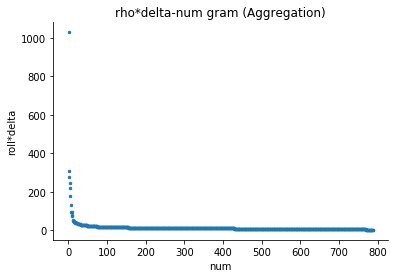

In [12]:
# rho*delta diagram
r_dA = np.sort(np.array(rollA)*np.array(deltaA))
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('num')
plt.ylabel('roll*delta')

ax.scatter(range(len(r_dA),0,-1), r_dA, marker='o', s=6)

plt.title('rho*delta-num gram (Aggregation)')
plt.show()

In [13]:
centerA, OODsA, clusterA = model.clustering(dataA, ratio=1.3, auto=False, cnum=7)

dc =  1.79756660106912


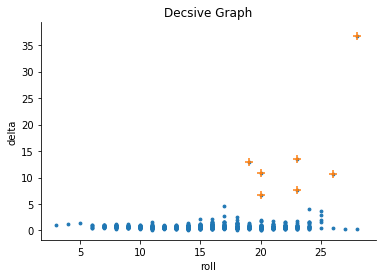

In [14]:
# plot decsive graph
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('roll')
plt.ylabel('delta')
color=[]
ax.scatter(rollA, deltaA, marker='o', s=8)

roll_delta = rollA * deltaA # 以roll*delta作为评价大小的指标
rcA = []
dcA = []
for i in centerA:
    rcA.append(rollA[i])
    dcA.append(deltaA[i])
ax.scatter(rcA, dcA, marker='+', s=60)

plt.title('Decsive Graph')
plt.show()

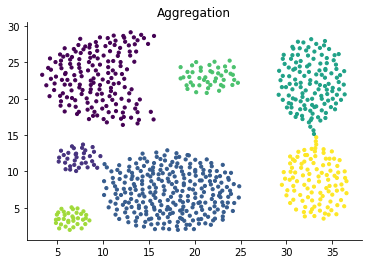

In [15]:
# plot clustering result
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

color = []
for i in range(len(clusterA)):
    if clusterA[i]==4:
        color.append(8)
    else:
        color.append(clusterA[i])
ax.scatter(dataA[:,0],dataA[:,1], c=color, marker='o', s=10)

plt.title('Aggregation')
plt.show()

In [16]:
# calculating DBI
metrics.davies_bouldin_score(dataA, clusterA)

0.5035680502991704

dc =  1.79756660106912
dc =  1.79756660106912
dc =  1.79756660106912
dc =  1.79756660106912
dc =  1.79756660106912
dc =  1.79756660106912


d:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


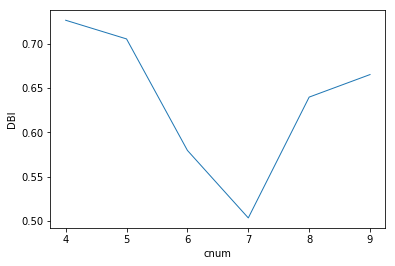

In [19]:
# manipulating parameters: cnum
DBIs = []
cnums = range(4,10,1)
for c in cnums:
    centerA, OODsA, clusterA = model.clustering(dataA, ratio=1.3, auto=False, cnum=c)
    DBIs.append(metrics.davies_bouldin_score(dataA, clusterA))

plt.figure()
plt.xlabel('cnum')
plt.ylabel('DBI')
ax = plt.axes()
plt.plot(cnums, DBIs, linewidth=1, linestyle="solid")
plt.show()

dc =  1.3827435392839384
dc =  1.5210178932123324
dc =  1.6592922471407263
dc =  1.79756660106912
dc =  1.9358409549975137
dc =  2.0741153089259075
dc =  2.2123896628543016
dc =  2.3506640167826953
dc =  2.488938370711089
dc =  2.627212724639483


d:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


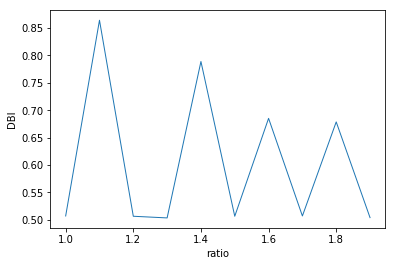

In [20]:
# manipulating parameters: ratio
DBIs = []
ratios = [1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
for ratio in ratios:
    center, OODs, cluster = model.clustering(dataA, ratio=ratio, auto=False, cnum=7)
    DBIs.append(metrics.davies_bouldin_score(dataA, cluster))
plt.figure()
plt.xlabel('ratio')
plt.ylabel('DBI')
ax = plt.axes()
plt.plot(ratios, DBIs, linewidth=1, linestyle="solid")
plt.show()

    D31

In [33]:
rollD, deltaD = model.decsive_graph(dataD, ratio=1.)

dc =  0.5937155693786215


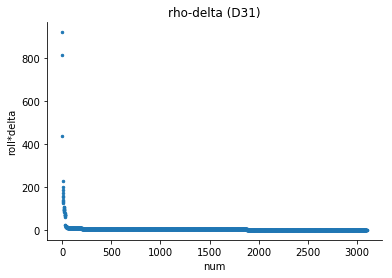

In [46]:
r_dD = np.sort(np.array(rollD)*np.array(deltaD))
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('num')
plt.ylabel('roll*delta')

ax.scatter(range(len(r_dD),0,-1), r_dD, marker='o', s=6)

plt.title('rho-delta (D31)')
plt.show()

In [34]:
centerD, OODsD, clusterD = model.clustering(dataD, ratio=1., auto=False, cnum=31)

dc =  0.5937155693786215


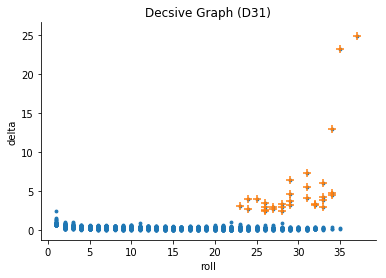

In [47]:
# plot decsive graph
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('roll')
plt.ylabel('delta')

ax.scatter(rollD, deltaD, marker='o', s=8)

roll_delta = rollD * deltaD # 以roll*delta作为评价大小的指标
rc = []
dc = []
for i in centerD:
    rc.append(rollD[i])
    dc.append(deltaD[i])
ax.scatter(rc, dc, marker='+', s=60)

plt.title('Decsive Graph (D31)')
plt.show()


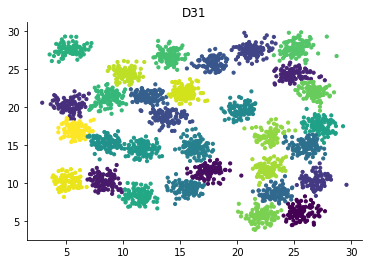

In [48]:
# plot clustering result
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

color = []
for i in range(len(clusterD)):
    if clusterD[i]==0:
        color.append(100)
    else:
        color.append(clusterD[i])

ax.scatter(dataD[:,0],dataD[:,1], c=color, marker='o', s=10)

plt.title('D31')
plt.show()

In [49]:
metrics.davies_bouldin_score(dataD, clusterD)

0.5528456005515475

dc =  0.7718302401922079
dc =  0.7718302401922079
dc =  0.7718302401922079
dc =  0.7718302401922079
dc =  0.7718302401922079
dc =  0.7718302401922079
dc =  0.7718302401922079


d:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


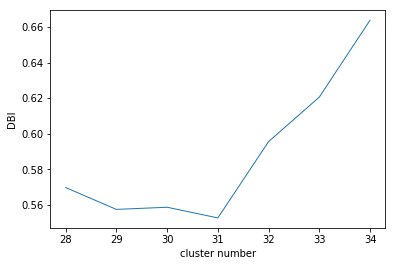

In [29]:
# manipulating parameters: cnum
DBIs = []
cnums = range(28,35,1)
for c in cnums:
    centerD, OODsD, clusterD = model.clustering(dataD, ratio=1.3, auto=False, cnum=c)
    DBIs.append(metrics.davies_bouldin_score(dataD, clusterD))
plt.figure()
plt.xlabel('cluster number')
plt.ylabel('DBI')
ax = plt.axes()
plt.plot(cnums, DBIs, linewidth=1, linestyle="solid")
plt.show()

dc =  0.7124586832543458
dc =  0.7718302401922079
dc =  0.83120179713007
dc =  0.8905733540679323
dc =  0.9499449110057945
dc =  1.0093164679436566


d:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


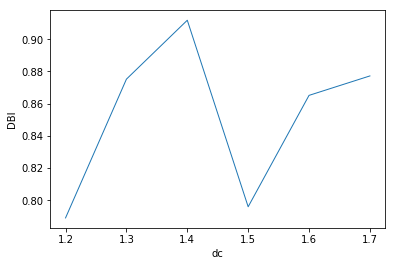

In [30]:
# manipulating parameters: ratio
DBIs = []
ratios = [1.2,1.3,1.4,1.5,1.6,1.7]
for ratio in ratios:
    center, OODs, cluster = model.clustering(dataD, ratio=ratio, auto=False, cnum=7)
    DBIs.append(metrics.davies_bouldin_score(dataD, cluster))
plt.figure()
plt.xlabel('dc')
plt.ylabel('DBI')
ax = plt.axes()
plt.plot(ratios, DBIs, linewidth=1, linestyle="solid")
plt.show()

    R15

dc =  0.5692314174978984


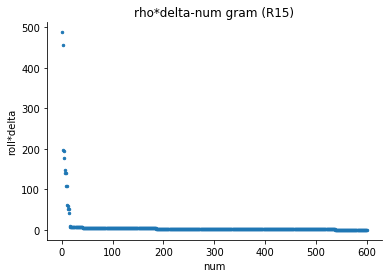

In [40]:
# rho*delta diagram
rollR, deltaR = model.decsive_graph(dataR, ratio=1.)

r_dR = np.sort(np.array(rollR)*np.array(deltaR))
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('num')
plt.ylabel('roll*delta')
ax.scatter(range(len(r_dR),0,-1), r_dR, marker='o', s=6)
plt.title('rho*delta-num gram (R15)')
plt.show()

dc =  0.5692314174978984


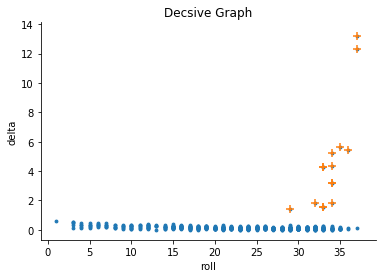

0.31481596929443234

In [41]:
# plot decsive graph
centerR, OODsR, clusterR = model.clustering(dataR, ratio=1., auto=False, cnum=15)

plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('roll')
plt.ylabel('delta')
color=[]
ax.scatter(rollR, deltaR, marker='o', s=8)

roll_delta = rollR * deltaR # 以roll*delta作为评价大小的指标
rcR = []
dcR = []
for i in centerR:
    rcR.append(rollR[i])
    dcR.append(deltaR[i])
ax.scatter(rcR, dcR, marker='+', s=60)
plt.title('Decsive Graph')
plt.show()
# calculating DBI
metrics.davies_bouldin_score(dataR, clusterR)

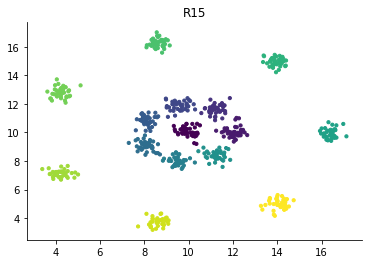

In [42]:
# plot clustering result
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

color = []
for i in range(len(clusterR)):
    if clusterR[i]==0:
        color.append(100)
    else:
        color.append(clusterR[i])
ax.scatter(dataR[:,0],dataR[:,1], c=color, marker='o', s=10)

plt.title('R15')
plt.show()

dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984
dc =  0.5692314174978984


d:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


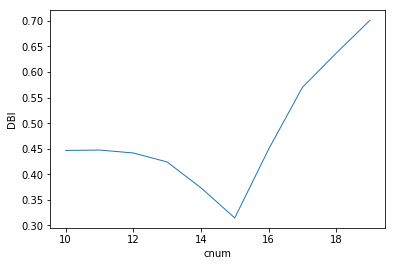

In [45]:
# manipulating parameters: cnum
DBIs = []
cnums = range(10,20,1)
for c in cnums:
    centerR, OODsR, clusterR = model.clustering(dataR, ratio=1., auto=False, cnum=c)
    DBIs.append(metrics.davies_bouldin_score(dataR, clusterR))

plt.figure()
plt.xlabel('cnum')
plt.ylabel('DBI')
ax = plt.axes()
plt.plot(cnums, DBIs, linewidth=1, linestyle="solid")
plt.show()

dc =  0.2846157087489492
dc =  0.34153885049873905
dc =  0.39846199224852885
dc =  0.4553851339983187
dc =  0.5123082757481086
dc =  0.5692314174978984
dc =  0.6261545592476883
dc =  0.6830777009974781
dc =  0.740000842747268
dc =  0.7969239844970577
dc =  0.8538471262468477
dc =  0.9107702679966374
dc =  0.9676934097464271
dc =  1.024616551496217
dc =  1.0815396932460069


d:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


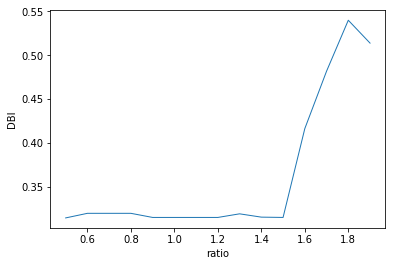

In [44]:
# manipulating parameters: ratio
DBIs = []
ratios = [0.5,0.6,0.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]
for ratio in ratios:
    center, OODs, cluster = model.clustering(dataR, ratio=ratio, auto=False, cnum=15)
    DBIs.append(metrics.davies_bouldin_score(dataR, cluster))
plt.figure()
plt.xlabel('ratio')
plt.ylabel('DBI')
ax = plt.axes()
plt.plot(ratios, DBIs, linewidth=1, linestyle="solid")
plt.show()